# **1. KHAI BÁO THƯ VIỆN**

**1.2. Khai báo một số thư viện cần thiết.**

In [1]:
#Import thư viện
import pandas as pd 
import numpy as np 
import datetime as dt 
from datetime import datetime
import matplotlib.pyplot as plt 
plt.style.use('bmh')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential #đầu vào
from keras.layers import Dense #dau ra
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from tensorflow import keras
import pandas_datareader.data as pdr
from keras.callbacks import ModelCheckpoint  
from tensorflow.keras.models import load_model 

from sklearn.metrics import r2_score # Mức độ phù hợp
from sklearn.metrics import mean_absolute_error #Tính sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error # Tính phần trăm sai số tuyệt đối trung bình


2022-12-23 22:09:34.784781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 22:09:35.859501: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-23 22:09:35.859572: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-23 22:09:40.186764: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

# **ĐỌC DỮ LIỆU TỪ FILE CSV**

In [2]:
class HandleCSV:
    def __init__(self):
        self.df = {}
        
    def createDataFrame(self, stockSymbolData):
        keys = list(stockSymbolData.keys())
        data = {}
        
        #Lấy cột ngày
        date = [i[0] for i in stockSymbolData[keys[0]]]
        date.reverse()
        
        data['Date'] = date
        
        #Lấy các cột mã chứng khoáng và giá đóng cửa
        for stockSymbol in keys:
            stockClosingPrice = [float(i[1]) for i in stockSymbolData[stockSymbol]]
            stockClosingPrice.reverse()
            
            data[stockSymbol] = stockClosingPrice
        
        self.df = pd.DataFrame(data)
        
    def exportCSV(self, fileName):
        self.df.to_csv(fileName, index = False, header=True)
        
    def readCSVToDataFrame(self, fileName):
        dataFrame = pd.read_csv(fileName)
        return dataFrame

In [3]:
handleCSV = HandleCSV()
closingPriceDataFrame = handleCSV.readCSVToDataFrame("ClosingPrice.csv")

df = closingPriceDataFrame.copy()
df.head(5)

,Date,FRT,TNT,LEC,TMT,VTB,EIB,ST8,APG,VND,...,TCO,VPH,HMC,HDB,CRE,HTI,CTF,CSV,KDH,LIX
0,04/01/2022,95.0,18.75,13.6,18.95,12.6,33.9,14.20,20.7,83.0,...,22.60,13.90,25.70,31.1,41.35,19.05,21.00,42.50,54.4,51.7
1,05/01/2022,94.0,18.25,13.7,18.50,12.6,34.3,14.10,20.4,82.1,...,22.35,14.85,25.45,30.5,42.00,19.30,21.25,42.50,55.7,51.6
2,06/01/2022,87.5,18.85,14.3,18.50,12.7,34.2,14.10,20.1,81.2,...,21.85,15.85,25.50,30.5,42.00,19.00,20.95,42.20,56.8,51.7
3,07/01/2022,88.8,18.90,13.7,18.00,12.7,33.4,13.85,20.3,80.0,...,21.95,16.95,25.30,30.3,43.40,19.25,20.50,41.55,56.6,53.5
4,10/01/2022,85.8,18.70,14.6,19.15,12.3,32.7,13.60,19.7,77.2,...,21.60,18.10,24.85,29.6,43.50,19.25,20.55,39.85,54.1,52.5


## Tạo index date cho Dataframe

In [4]:
format = '%d/%m/%Y'
df['Date'] = pd.to_datetime(df['Date'], format = format)
df = df.set_index('Date')


,FRT,TNT,LEC,TMT,VTB,EIB,ST8,APG,VND,TDM,...,TCO,VPH,HMC,HDB,CRE,HTI,CTF,CSV,KDH,LIX
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-04,95.0,18.75,13.6,18.95,12.6,33.9,14.20,20.7,83.0,35.00,...,22.60,13.90,25.70,31.1,41.35,19.05,21.00,42.50,54.4,51.7
2022-01-05,94.0,18.25,13.7,18.50,12.6,34.3,14.10,20.4,82.1,34.50,...,22.35,14.85,25.45,30.5,42.00,19.30,21.25,42.50,55.7,51.6
2022-01-06,87.5,18.85,14.3,18.50,12.7,34.2,14.10,20.1,81.2,33.95,...,21.85,15.85,25.50,30.5,42.00,19.00,20.95,42.20,56.8,51.7
2022-01-07,88.8,18.90,13.7,18.00,12.7,33.4,13.85,20.3,80.0,34.20,...,21.95,16.95,25.30,30.3,43.40,19.25,20.50,41.55,56.6,53.5
2022-01-10,85.8,18.70,14.6,19.15,12.3,32.7,13.60,19.7,77.2,34.15,...,21.60,18.10,24.85,29.6,43.50,19.25,20.55,39.85,54.1,52.5


In [41]:
df.head(5)

,FRT,TNT,LEC,TMT,VTB,EIB,ST8,APG,VND,TDM,...,TCO,VPH,HMC,HDB,CRE,HTI,CTF,CSV,KDH,LIX
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-04,95.0,18.75,13.6,18.95,12.6,33.9,14.20,20.7,83.0,35.00,...,22.60,13.90,25.70,31.1,41.35,19.05,21.00,42.50,54.4,51.7
2022-01-05,94.0,18.25,13.7,18.50,12.6,34.3,14.10,20.4,82.1,34.50,...,22.35,14.85,25.45,30.5,42.00,19.30,21.25,42.50,55.7,51.6
2022-01-06,87.5,18.85,14.3,18.50,12.7,34.2,14.10,20.1,81.2,33.95,...,21.85,15.85,25.50,30.5,42.00,19.00,20.95,42.20,56.8,51.7
2022-01-07,88.8,18.90,13.7,18.00,12.7,33.4,13.85,20.3,80.0,34.20,...,21.95,16.95,25.30,30.3,43.40,19.25,20.50,41.55,56.6,53.5
2022-01-10,85.8,18.70,14.6,19.15,12.3,32.7,13.60,19.7,77.2,34.15,...,21.60,18.10,24.85,29.6,43.50,19.25,20.55,39.85,54.1,52.5


### **Lấy giá cổ phiếu đóng cửa của VJC.**

In [5]:

data_VJC = df.filter(['VJC'])

data_VJC.columns = data_VJC.columns.str.replace('VJC', 'Close')
data_VJC

,Close
Date,
2022-01-04,126.0
2022-01-05,123.0
2022-01-06,123.8
2022-01-07,123.8
2022-01-10,123.8
...,...
2020-12-25,125.9
2020-12-28,124.9
2020-12-29,125.6


In [39]:
# Thông tin về data.
data_VJC.head()

,Close
2020-01-01,147.0
2020-01-02,147.0
2020-01-03,147.0
2020-01-04,147.0
2020-01-05,147.0


In [40]:
# Thông tin về data.
data_VJC.tail()

,Close
2022-04-26,129.0
2022-04-27,129.0
2022-04-28,129.0
2022-04-29,129.9
2022-04-30,129.9


In [6]:
# Thông tin về data.
data_VJC.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 527 entries, 2022-01-04 to 2020-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   527 non-null    float64
dtypes: float64(1)
memory usage: 8.2 KB


In [7]:
# Thông tin về data.
data_VJC.describe()

,Close
count,527.00000
mean,121.03074
std,12.32589
min,94.50000
25%,113.00000
50%,122.00000
75%,130.30000
max,149.00000


# **XỬ LÝ DỮ LIỆU.**

### Xử lý dữ liệu bị thiếu

In [8]:
all_days = pd.date_range('1/1/2020', '30/4/2022', freq='D')
data_VJC = data_VJC.reindex(all_days)

/tmp/ipykernel_25274/1712108064.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  all_days = pd.date_range('1/1/2020', '30/4/2022', freq='D')


In [9]:
data_VJC = data_VJC.fillna(method='ffill')
data_VJC = data_VJC.fillna(method='bfill')

### Kiểm tra còn dữ liệu NaN hoặc Null không

In [10]:
data_VJC.isna().sum().sum()

0

In [11]:
data_VJC.isnull().sum().sum()

0

### **Lấy dữ liệu 4 tháng đầu năm 2022 của VJC.**

In [12]:
data_VJC_2022 = data_VJC.loc['2022-1-1':'2022-4-30']

In [13]:
data_VJC_2022.head()

,Close
2022-01-01,128.3
2022-01-02,128.3
2022-01-03,128.3
2022-01-04,126.0
2022-01-05,123.0


In [14]:
data_VJC_2022.tail()


,Close
2022-04-26,129.0
2022-04-27,129.0
2022-04-28,129.0
2022-04-29,129.9
2022-04-30,129.9


In [15]:
data_VJC_2022.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2022-01-01 to 2022-04-30
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   120 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


In [16]:
data_VJC_2022.describe()

,Close
count,120.000000
mean,134.685000
std,9.033873
min,120.500000
25%,123.800000
50%,138.150000
75%,141.125000
max,149.000000


## Trực quan hóa dữ liệu 

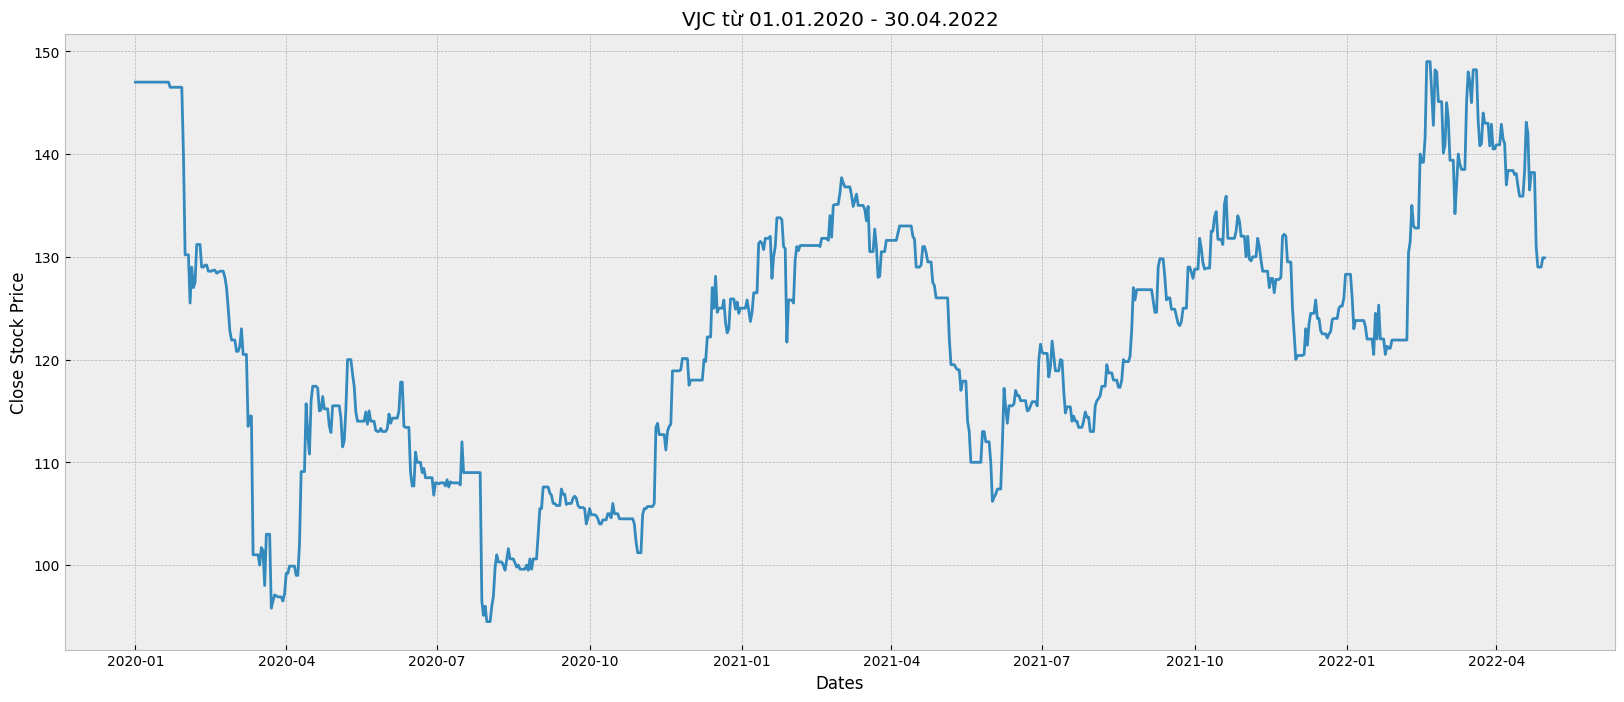

In [17]:
#Trực quan hóa giá đóng cửa 01.01.2020 - 01.06.2022.
plt.figure(figsize = (20,8))
plt.plot(data_VJC['Close'])
plt.title("VJC từ 01.01.2020 - 30.04.2022")
plt.xlabel('Dates')
plt.ylabel('Close Stock Price')
plt.show()

## **Chia dữ liệu thành tập train và test.**

In [18]:
len(data_VJC.values)

851

In [19]:

data  = data_VJC.values 
train_data = data[:730] 
test_data =  data[730:]

In [20]:
len(train_data)

730

In [21]:
len(test_data)

121

## **Chuẩn hóa dữ liệu, sử dụng tập train để train model.**

In [22]:
#Chuẩn hóa dữ liệu.
sc = MinMaxScaler(feature_range=(0,1))
scaled_data = sc.fit_transform(data.reshape(-1,1))
len(scaled_data)

851

### Chia tập train thành x_train, y_train

In [23]:


prediction_days = 40
x_train = [] #chứa giá trị của 40 ngày liên tiếp.
y_train = [] #chứa giá trị của ngày tiếp theo.
for x in range(prediction_days, len(train_data)):
  x_train.append(scaled_data[x-prediction_days:x, 0])
  y_train.append(scaled_data[x, 0])

In [24]:
x_train

[array([0.96330275, 0.96330275, 0.96330275, 0.96330275, 0.96330275,
        0.96330275, 0.96330275, 0.96330275, 0.96330275, 0.96330275,
        0.96330275, 0.96330275, 0.96330275, 0.96330275, 0.96330275,
        0.96330275, 0.96330275, 0.96330275, 0.96330275, 0.96330275,
        0.96330275, 0.95412844, 0.95412844, 0.95412844, 0.95412844,
        0.95412844, 0.95412844, 0.95412844, 0.95412844, 0.83486239,
        0.65504587, 0.65504587, 0.65504587, 0.56880734, 0.63302752,
        0.59633028, 0.60550459, 0.6733945 , 0.6733945 , 0.6733945 ]),
 array([0.96330275, 0.96330275, 0.96330275, 0.96330275, 0.96330275,
        0.96330275, 0.96330275, 0.96330275, 0.96330275, 0.96330275,
        0.96330275, 0.96330275, 0.96330275, 0.96330275, 0.96330275,
        0.96330275, 0.96330275, 0.96330275, 0.96330275, 0.96330275,
        0.95412844, 0.95412844, 0.95412844, 0.95412844, 0.95412844,
        0.95412844, 0.95412844, 0.95412844, 0.83486239, 0.65504587,
        0.65504587, 0.65504587, 0.56880734, 0.

In [25]:
y_train

[0.6330275229357798,
 0.6330275229357798,
 0.6366972477064219,
 0.6366972477064219,
 0.6256880733944956,
 0.6256880733944956,
 0.6256880733944956,
 0.6275229357798162,
 0.6275229357798162,
 0.6220183486238535,
 0.6238532110091746,
 0.6256880733944956,
 0.6256880733944956,
 0.6256880733944956,
 0.6146788990825689,
 0.596330275229358,
 0.5596330275229358,
 0.5192660550458714,
 0.502752293577982,
 0.502752293577982,
 0.502752293577982,
 0.4825688073394496,
 0.4825688073394496,
 0.4917431192660553,
 0.522935779816514,
 0.4770642201834865,
 0.4770642201834865,
 0.4770642201834865,
 0.3486238532110093,
 0.3669724770642202,
 0.3669724770642202,
 0.11926605504587151,
 0.11926605504587151,
 0.11926605504587151,
 0.11926605504587151,
 0.10091743119266061,
 0.13211009174311927,
 0.12660550458715614,
 0.06422018348623859,
 0.15596330275229375,
 0.15596330275229375,
 0.15596330275229375,
 0.023853211009174258,
 0.03669724770642202,
 0.047706422018348515,
 0.04587155963302747,
 0.044036697247706647,

### Xếp dữ liệu thành mảng 1 chiều.

In [26]:
x_train, y_train = np.array(x_train), np.array(y_train) #Chuyển dữ liệu sang 1 mảng.

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) 
y_train = np.reshape(y_train,(y_train.shape[0], 1))

In [27]:
x_train

array([[[0.96330275],
        [0.96330275],
        [0.96330275],
        ...,
        [0.6733945 ],
        [0.6733945 ],
        [0.6733945 ]],

       [[0.96330275],
        [0.96330275],
        [0.96330275],
        ...,
        [0.6733945 ],
        [0.6733945 ],
        [0.63302752]],

       [[0.96330275],
        [0.96330275],
        [0.96330275],
        ...,
        [0.6733945 ],
        [0.63302752],
        [0.63302752]],

       ...,

       [[0.58715596],
        [0.61100917],
        [0.61100917],
        ...,
        [0.5412844 ],
        [0.5412844 ],
        [0.55963303]],

       [[0.61100917],
        [0.61100917],
        [0.61100917],
        ...,
        [0.5412844 ],
        [0.55963303],
        [0.56330275]],

       [[0.61100917],
        [0.61100917],
        [0.6146789 ],
        ...,
        [0.55963303],
        [0.56330275],
        [0.56330275]]])

In [28]:
y_train

array([[0.63302752],
       [0.63302752],
       [0.63669725],
       [0.63669725],
       [0.62568807],
       [0.62568807],
       [0.62568807],
       [0.62752294],
       [0.62752294],
       [0.62201835],
       [0.62385321],
       [0.62568807],
       [0.62568807],
       [0.62568807],
       [0.6146789 ],
       [0.59633028],
       [0.55963303],
       [0.51926606],
       [0.50275229],
       [0.50275229],
       [0.50275229],
       [0.48256881],
       [0.48256881],
       [0.49174312],
       [0.52293578],
       [0.47706422],
       [0.47706422],
       [0.47706422],
       [0.34862385],
       [0.36697248],
       [0.36697248],
       [0.11926606],
       [0.11926606],
       [0.11926606],
       [0.11926606],
       [0.10091743],
       [0.13211009],
       [0.1266055 ],
       [0.06422018],
       [0.1559633 ],
       [0.1559633 ],
       [0.1559633 ],
       [0.02385321],
       [0.03669725],
       [0.04770642],
       [0.04587156],
       [0.0440367 ],
       [0.044

# **BUILT MODEL**

**4.1 Model**

In [29]:
model = Sequential()
model.add(LSTM(units = 128,input_shape=(x_train.shape[1],1),return_sequences = True))
model.add(LSTM(units = 64))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam',)

2022-12-23 22:09:47.863062: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-23 22:09:47.863635: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-23 22:09:47.863738: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tin-Lenovo-YOGA-510-15ISK): /proc/driver/nvidia/version does not exist
2022-12-23 22:09:47.865433: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Huấn luyện model**

In [30]:
save_model = "save_model.hdf5"
best_model = ModelCheckpoint(save_model,monitor='loss',verboss=2,save_best_only = True,model="auto")
model.fit(x_train,y_train,epochs=10,batch_size=50,verbose=2,callbacks=[best_model])


Epoch 1/10
14/14 - 10s - loss: 0.0625 - 10s/epoch - 738ms/step
Epoch 2/10
14/14 - 3s - loss: 0.0172 - 3s/epoch - 180ms/step
Epoch 3/10
14/14 - 2s - loss: 0.0108 - 2s/epoch - 173ms/step
Epoch 4/10
14/14 - 2s - loss: 0.0103 - 2s/epoch - 132ms/step
Epoch 5/10
14/14 - 2s - loss: 0.0083 - 2s/epoch - 120ms/step
Epoch 6/10
14/14 - 2s - loss: 0.0081 - 2s/epoch - 116ms/step
Epoch 7/10
14/14 - 2s - loss: 0.0073 - 2s/epoch - 114ms/step
Epoch 8/10
14/14 - 2s - loss: 0.0074 - 2s/epoch - 120ms/step
Epoch 9/10
14/14 - 2s - loss: 0.0076 - 2s/epoch - 125ms/step
Epoch 10/10
14/14 - 2s - loss: 0.0070 - 2s/epoch - 119ms/step


In [31]:
#Tải model thực hiện train cho y_train.
y_train = sc.inverse_transform(y_train) #giá thực
final_model = load_model('save_model.hdf5')

# Thực hiện dự đoán cho y train.
y_train_predict = final_model.predict(x_train)
y_train_predict = sc.inverse_transform(y_train_predict) #giá dự đoán

22/22 [==============================] - 2s 43ms/step


# **THỰC HIỆN ÁP DỤNG MODEL DỰ ĐOÁN CHO TẬP TEST.**

### **Xử lý dữ liệu cho tập Test**

In [32]:
#Xử lý dữ liệu test
test = data_VJC[len(train_data)-40:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(40,test.shape[0]):
    x_test.append(sc_test[i-40:i,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

### **Thực hiện áp dụng model dự đoán cho tập Test.**

In [33]:
#Thực hiện áp dụng model dự đoán cho tập test.
y_test = data[730:] #giá thực tế.
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán


4/4 [==============================] - 0s 36ms/step


# **HIỂN THỊ KẾT QUẢ.**

/tmp/ipykernel_25274/4015639308.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_train_data['Predic'] = y_train_predict #Dữ liệu do model dự đoán tập train.
/tmp/ipykernel_25274/4015639308.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_test_data['Predic'] = y_test_predict #Dữ liệu do model dự đoán tập test.


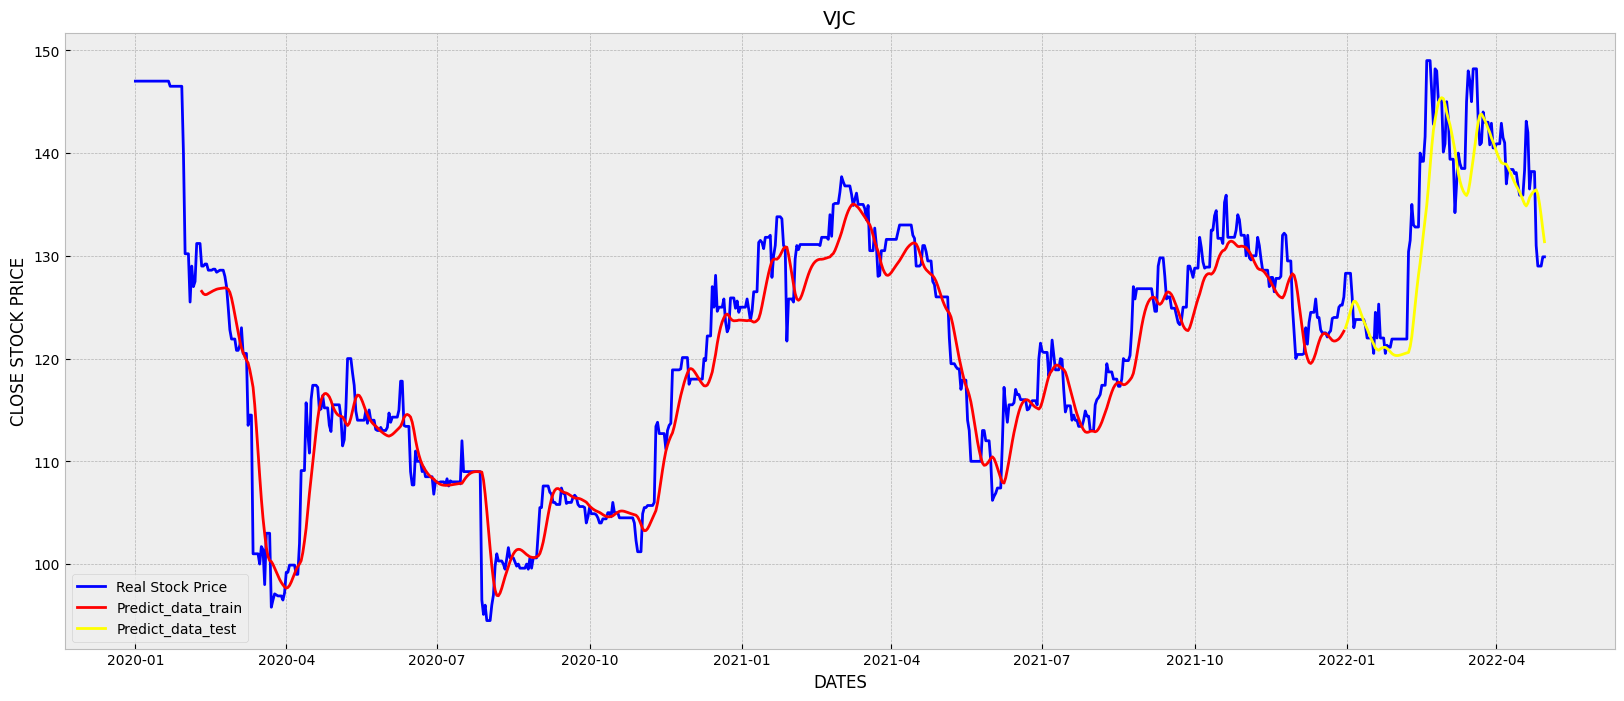

In [34]:
#Trực quan hóa bằng biểu đồ.
new_train_data = data_VJC[40:730]
new_test_data = data_VJC[730:]
plt.figure(figsize = (20,8))

plt.plot(data_VJC, label = 'Real Stock Price',color = 'blue') #Đường giá thực

new_train_data['Predic'] = y_train_predict #Dữ liệu do model dự đoán tập train.
plt.plot(new_train_data['Predic'],label='Predict_data_train',color='red') #Vẽ đường giá dự báo train.

new_test_data['Predic'] = y_test_predict #Dữ liệu do model dự đoán tập test.
plt.plot(new_test_data["Predic"],label='Predict_data_test',color='yellow') #Vẽ đường giá dự báo test.

plt.title('VJC')
plt.xlabel('DATES') 
plt.ylabel('CLOSE STOCK PRICE') 
plt.legend() 
plt.show()

# **7. KIỂM TRA ĐỘ CHÍNH XÁC CỦA MODEL**

In [35]:
new_train_data 

,Close,Predic
2020-02-10,129.0,126.545464
2020-02-11,129.0,126.313591
2020-02-12,129.2,126.221413
2020-02-13,129.2,126.239655
2020-02-14,128.6,126.330734
...,...,...
2021-12-26,124.0,121.801582
2021-12-27,125.0,121.921387
2021-12-28,125.2,122.123505
2021-12-29,125.2,122.383148


In [36]:
new_test_data

,Close,Predic
2021-12-31,128.3,122.996262
2022-01-01,128.3,123.485031
2022-01-02,128.3,124.055748
2022-01-03,128.3,124.647240
2022-01-04,126.0,125.212288
...,...,...
2022-04-26,129.0,135.991394
2022-04-27,129.0,135.084732
2022-04-28,129.0,133.900787
2022-04-29,129.9,132.601135


**Độ chính xác tập train.**

In [37]:
print('Độ chính xác:',r2_score(y_train,y_train_predict))
print('Sai số tuyệt đối trung bình:',mean_absolute_error(y_train,y_train_predict))
print('Phần trăm sai số tuyệt đối trung bình:',mean_absolute_percentage_error(y_train,y_train_predict))

Độ chính xác: 0.9136925780397501
Sai số tuyệt đối trung bình: 2.264850541266842
Phần trăm sai số tuyệt đối trung bình: 0.01927440712862365


**Độ chính xác tập test.**

In [38]:
print('Độ chính xác:',r2_score(y_test,y_test_predict))
print('Sai số tuyệt đối trung bình:',mean_absolute_error(y_test,y_test_predict))
print('Phần trăm sai số tuyệt đối trung bình:',mean_absolute_percentage_error(y_test,y_test_predict))

Độ chính xác: 0.736804238833914
Sai số tuyệt đối trung bình: 3.1767318347268865
Phần trăm sai số tuyệt đối trung bình: 0.023109382501328483
